In [1]:
import warnings
import os
warnings.filterwarnings("ignore") 

# Suppress TensorFlow logging messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import json
import os
import pandas as pd
import pysam
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from basenji import seqnn, stream, dataset, dna_io

from akita_utils.numpy_utils import ut_dense
from akita_utils.dna_utils import dna_1hot

In [2]:
# read data parameters
mouse_dir = "/project/fudenber_735/tensorflow_models/akita/v2/data/mm10/"
data_stats_file = '%s/statistics.json' % mouse_dir
with open(data_stats_file) as data_stats_open:
    data_stats = json.load(data_stats_open)
seq_length = data_stats['seq_length']
target_length = data_stats['target_length']
hic_diags =  data_stats['diagonal_offset']
target_crop = data_stats['crop_bp'] // data_stats['pool_width']
target_length1 = data_stats['seq_length'] // data_stats['pool_width']

In [3]:
AkitaV2_testset_path = "/project/fudenber_735/tensorflow_models/akita/v2/data/mm10/sequences.bed"

In [4]:
AkitaV2_testset = pd.read_csv(AkitaV2_testset_path, sep='\t', names=['chr','start','stop','type'])

In [5]:
seq_len_nt = 1310720

# chrom = "chr14"
# start = 57431119
# end = 57431119 + seq_len_nt

# chrom = "chr2"
# start = 78799277
# end = 78799277 + seq_len_nt

# chrom = "chr4"
# start = 10238626
# end = 10238626 + seq_len_nt

# chrom = "chr3"
# start = 52299397
# end = 52299397 + seq_len_nt

# chrom = "chr3"
# start = 33348564
# end = 33348564 + seq_len_nt

chrom = "chr1"
start = 57299397
end = 57299397 + seq_len_nt

# chrom = "chr1"
# start = 65725093
# end = 65725093 + seq_len_nt

# chrom = "chr6"
# start = 48284868
# end = 48284868 + seq_len_nt

# chrom = "chr7"
# start = 71039589
# end = 71039589 + seq_len_nt

# chrom = "chr9"
# start = 62615475
# end = 62615475 + seq_len_nt

In [6]:
AkitaV2_testset[(AkitaV2_testset["start"] < start) & (AkitaV2_testset["chr"] == chrom) & (AkitaV2_testset["stop"] > start)]
# (AkitaV2_testset["start"] < start) & 

,chr,start,stop,type
1252,chr1,56184832,57495552,fold1
1274,chr1,56512512,57823232,fold1
1418,chr1,56840192,58150912,fold1
1439,chr1,57167872,58478592,fold1


In [7]:
# model's parameters
batch_size=8 
head_index = 1 # mouse!
shifts = "0"
rc = False
shifts = [int(shift) for shift in shifts.split(",")]

# directory with models
models_dir = "/project/fudenber_735/tensorflow_models/akita/v2/models"

In [8]:
# open genome FASTA
genome_fasta = "/project/fudenber_735/genomes/mm10/mm10.fa"
genome_open = pysam.Fastafile(genome_fasta)

# picking the model
model_index = 1
# model_index = 5

In [9]:
params_file = models_dir + f"/f{model_index}c0" + "/train" + "/params.json"
model_file = models_dir + f"/f{model_index}c0" + "/train" + f"/model{head_index}_best.h5"

# read model parameters
with open(params_file) as params_open:
    params = json.load(params_open)
params_train = params["train"]
params_model = params["model"]

if batch_size is None:
    batch_size = params_train["batch_size"]
else:
    batch_size = batch_size

# load model
seqnn_model = seqnn.SeqNN(params_model)
seqnn_model.restore(model_file, head_i=head_index)
seqnn_model.build_ensemble(rc, shifts)
seq_length = int(params_model["seq_length"])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 1310720, 4)]         0         []                            
                                                                                                  
 stochastic_reverse_complem  ((None, 1310720, 4),         0         ['sequence[0][0]']            
 ent (StochasticReverseComp   ())                                                                 
 lement)                                                                                          
                                                                                                  
 stochastic_shift (Stochast  (None, 1310720, 4)           0         ['stochastic_reverse_complemen
 icShift)                                                           t[0][0]']               

In [10]:
# fetching
seq_1hot = dna_1hot(
        genome_open.fetch(
            chrom, start, end
        ).upper()
    )
expanded_seq_1hot = np.expand_dims(seq_1hot, 0)

In [11]:
test_pred = seqnn_model.model.predict(expanded_seq_1hot)

1/1 [==============================] - 3s 3s/step


In [12]:
test_pred_maps = ut_dense(test_pred[0,:,:])

In [13]:
preds = [test_pred_maps[:,:,i] for i in range(6)]

In [14]:
def plot_maps_with_labels(maps, labels, vmin=-0.6, vmax=0.6, palette="RdBu_r", width=20, height=5):
    fig, axes = plt.subplots(1, len(maps), figsize=(width, height))

    for i, (matrix, label) in enumerate(zip(maps, labels)):
        sns.heatmap(
            matrix,
            vmin=vmin,
            vmax=vmax,
            cbar=False,
            cmap=palette,
            square=True,
            xticklabels=False,
            yticklabels=False,
            ax=axes[i]
        )
        axes[i].set_title(label, fontsize=12)  # Set the label above the heatmap

    plt.tight_layout()
    plt.show()

In [15]:
labels = ["mESC", "mESC", "cortical neuron", "neocortex cortical neuron", "neural progenitor cell", "neocortex neural progenitor cell"]

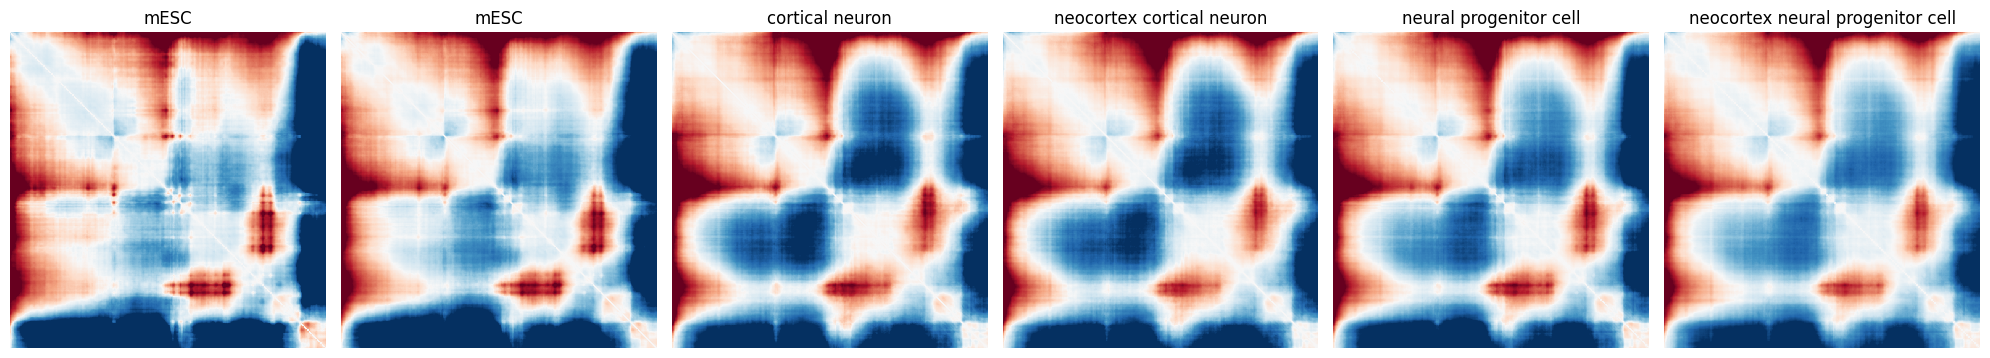

In [16]:
plot_maps_with_labels(preds, labels)

In [17]:
genome_open.close()

### Comparing with Targets

In [ ]:
# mouse targets
# index   identifier      file    description
# 0       Hsieh2019_mESC_uC       /home/drk/hic/data/data/coolers/mm10/Hsieh2019/mESC_mm10_4DNFILZ1CPT8.mapq_30.2048.cool HIC:mESC
# 1       Bonev2017_mESC  /home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_ES_all.mm10.mapq_30.2048.cool        HIC:mESC
# 2       Bonev2017_CN    /home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_CN_all.mm10.mapq_30.2048.cool        HIC:cortical neuron
# 3       Bonev2017_ncx_CN        /home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_ncx_CN_all.mm10.mapq_30.2048.cool    HIC:neocortex cortical neuron
# 4       Bonev2017_NPC   /home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_NPC_all.mm10.mapq_30.2048.cool       HIC:neural progenitor cell
# 5       Bonev2017_ncx_NPC       /home/drk/hic/data/data/coolers/mm10/Bonev2017/HiC_ncx_NPC_all.mm10.mapq_30.2048.cool   HIC:neocortex neural progenitor cell

In [18]:
cool_paths = {"Hsieh2019_mESC_uC_path" : "/project/fudenber_735/GEO/Hsieh2019/4DN/mESC_mm10_4DNFILZ1CPT8.mapq_30.2048.cool",
"Bonev2017_mESC_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ES_all.mm10.mapq_30.2048.cool",
"Bonev2017_CN_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_CN_all.mm10.mapq_30.2048.cool",
"Bonev2017_ncx_CN_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ncx_CN_all.mm10.mapq_30.2048.cool",
"Bonev2017_NPC_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_NPC_all_mm10.mapq_30.1024.cool",
"Bonev2017_ncx_NPC_path" : "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ncx_NPC_all.mm10.mapq_30.2048.cool"}

In [19]:
import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import pandas as pd
import cooler
from cooltools.lib.numutils import observed_over_expected, adaptive_coarsegrain
from cooltools.lib.numutils import interpolate_bad_singletons, set_diag, interp_nan
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

In [20]:
def get_target(cooler_path, padding, mseq_str, diagonal_offset=2):
    
    genome_hic_cool = cooler.Cooler(cooler_path)
    
    seq_hic_raw = genome_hic_cool.matrix(balance=True).fetch(mseq_str)

    seq_hic_nan = np.isnan(seq_hic_raw)
    # num_filtered_bins = np.sum(np.sum(seq_hic_nan,axis=0) == len(seq_hic_nan))

    # clip first diagonals and high values
    clipval = np.nanmedian(np.diag(seq_hic_raw, diagonal_offset))
    for i in range(-diagonal_offset+1, diagonal_offset):
        set_diag(seq_hic_raw, clipval, i)
    seq_hic_raw = np.clip(seq_hic_raw, 0, clipval)
    seq_hic_raw[seq_hic_nan] = np.nan
    
    # adaptively coarsegrain based on raw counts
    seq_hic_smoothed = adaptive_coarsegrain(
                        seq_hic_raw,
                        genome_hic_cool.matrix(balance=False).fetch(mseq_str),
                        cutoff=2, max_levels=8)
    seq_hic_nan = np.isnan(seq_hic_smoothed)
    
    # local obs/exp
    seq_hic_obsexp = observed_over_expected(seq_hic_smoothed, ~seq_hic_nan)[0]
    log_hic_obsexp = np.log(seq_hic_obsexp)

    # crop
    if padding > 0:
        log_hic_obsexp = log_hic_obsexp[padding:-padding,:]
        log_hic_obsexp = log_hic_obsexp[:,padding:-padding]

    # aplying Gaussian Kernel
    kernel = Gaussian2DKernel(x_stddev=1)
    kernel_log_hic_obsexp = convolve(log_hic_obsexp, kernel)
    
    return kernel_log_hic_obsexp

In [21]:
seq_len_nt = 1310720
padding = (640-512) // 2

# chrom = "chr3"
# start = 33348564
# end = 33348564 + seq_len_nt

# chrom = "chr14"
# gene_start = 58083863
# gene_end = 58089096

# chrom = "chr2"
# gene_start = 79452639
# gene_end = 79456636

# chrom = "chr4"
# gene_start = 10881264
# gene_end = 10906709

# chrom = "chr1"
# gene_start = 66321719
# gene_end = 66439188

# chrom = "chr1"
# start = 57299397
# end = 57299397 + seq_len_nt

# chrom = "chr7"
# start = 71039589
# end = 71039589 + seq_len_nt

# gene_length = gene_end - gene_start

# if gene_length % 2 == 1:
#     gene_start = gene_start - 1

# if gene_length < seq_len_nt:
#     difference = (seq_len_nt - (gene_end - gene_start))
#     start = gene_start - (difference // 2)
# else:
#     start = gene_start
    
# end = start + seq_len_nt

In [22]:
mseq_str = '%s:%d-%d' % (chrom, start, end)

In [23]:
mseq_str

'chr1:57299397-58610117'

In [24]:
targets = []

for path in cool_paths:
    targets.append(get_target(cool_paths[path], padding, mseq_str))

In [25]:
def average_pooling(mat, pool_size=2):
    """
    Reduces the size of an 1153x1153 matrix to 513x513 using average pooling.
    Handles matrices that are not perfectly divisible by 2.
    """
    # Crop the matrix to 1152x1152 (since 1153 is not divisible by 2)
    mat_cropped = mat[:1152, :1152]

    # Apply average pooling manually by taking the average over 2x2 blocks
    pooled_mat = np.zeros((513, 513))
    for i in range(513):
        for j in range(513):
            pooled_mat[i, j] = np.mean(mat_cropped[i*2:i*2+2, j*2:j*2+2])
    
    return pooled_mat

In [26]:
targets[4] = average_pooling(targets[4])

In [27]:
for i in range(6):
    targets[i] = np.nan_to_num(targets[i], nan=0)

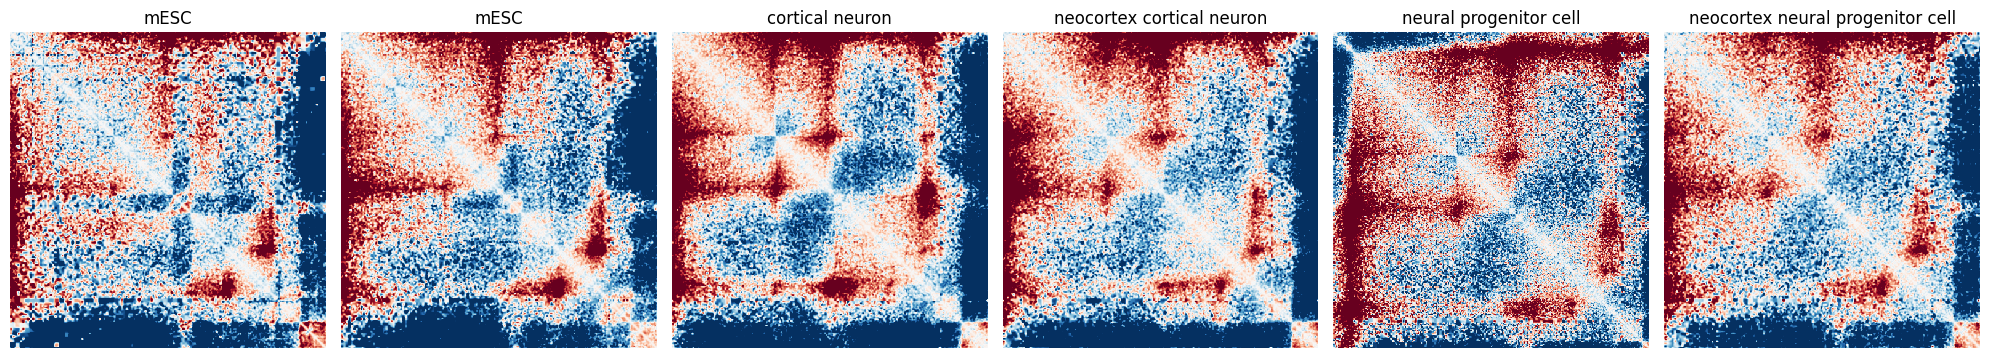

In [28]:
plot_maps_with_labels(targets, labels)

In [29]:
from scipy.stats import pearsonr, ttest_rel

In [ ]:
# for i in range(6):
#     print(np.isnan(preds[i]).any())

In [ ]:
# for i in range(6):
#     print(np.isnan(targets[i]).any())

In [30]:
def trim_matrix(mat):
    return mat[:-1, :-1] 

def correlation_matrix(mat1, mat2):
    """Calculate Pearson correlation between two 512x512 matrices."""
    mat1_flat = mat1.flatten()
    mat2_flat = mat2.flatten()
    return pearsonr(mat1_flat, mat2_flat)[0]  # Pearson correlation coefficient

def get_correlations(preds, targets):
    num_cell_types = len(targets)
    
    # Lists to store correlations
    target_vs_target_corr = []
    pred_vs_target_corr = []
    
    for i in range(num_cell_types):
        for j in range(num_cell_types):
            # Trim the target matrices (513x513 -> 512x512)
            target_i_trimmed = trim_matrix(targets[i])
            target_j_trimmed = trim_matrix(targets[j])
            
            # Trim predicted matrix (if needed)
            pred_i = preds[i]  # Assuming preds are already 512x512

            # Calculate target vs target correlations
            target_corr = correlation_matrix(target_i_trimmed, target_j_trimmed)
            target_vs_target_corr.append((i, j, target_corr))  # (cell_type1, cell_type2, correlation)

            # Calculate predicted vs target correlations
            pred_corr = correlation_matrix(pred_i, target_j_trimmed)
            pred_vs_target_corr.append((i, j, pred_corr))  # (cell_type1, cell_type2, correlation)
    
    return target_vs_target_corr, pred_vs_target_corr

def paired_t_test(target_vs_target_corr, pred_vs_target_corr):
    """
    Perform paired t-test to compare target vs target correlations
    with pred vs target correlations.
    """
    specific_corr_diff = []  # List of differences between specific correlations
    nonspecific_corr_diff = []  # List of differences between non-specific correlations

    for (i1, j1, target_corr), (i2, j2, pred_corr) in zip(target_vs_target_corr, pred_vs_target_corr):
        assert i1 == i2 and j1 == j2  # Ensure we are comparing the same pairs

        if i1 == j1:  # Within-cell type (specific)
            specific_corr_diff.append(pred_corr - target_corr)
        else:  # Cross-cell type (non-specific)
            nonspecific_corr_diff.append(pred_corr - target_corr)

    # Perform paired t-test
    specific_stat, specific_p = ttest_rel([x for x in specific_corr_diff], [0]*len(specific_corr_diff))
    nonspecific_stat, nonspecific_p = ttest_rel([x for x in nonspecific_corr_diff], [0]*len(nonspecific_corr_diff))
    
    return specific_stat, specific_p, nonspecific_stat, nonspecific_p

In [31]:
target_vs_target_corr, pred_vs_target_corr = get_correlations(preds, targets)
# target_vs_target_corr -> This is a list that stores the correlations between target matrices.
# pred_vs_target_corr -> This is a list that stores the correlations between predicted matrices and target matrices.

In [32]:
specific_stat, specific_p, nonspecific_stat, nonspecific_p = paired_t_test(target_vs_target_corr, pred_vs_target_corr)

In [33]:
print(f"Specific correlations t-statistic: {specific_stat}, p-value: {specific_p}")

Specific correlations t-statistic: -2.8651411904299344, p-value: 0.03519406353034051


In [ ]:
# The t-statistic is negative, indicating that the predicted correlations tend to be lower than the target correlations within the same cell type.
# The model’s predictions for within-cell-type (specific) correlations are statistically significantly lower than the target correlations. 
# This suggests that the model may struggle to fully capture the precise contact frequency patterns specific to each cell type.

In [ ]:
print(f"Non-specific correlations t-statistic: {nonspecific_stat}, p-value: {nonspecific_p}")

In [ ]:
# The positive t-statistic indicates that the predicted correlations tend to be higher than the target correlations across different cell types.
# The model’s predictions for non-specific (cross-cell-type) correlations are statistically significantly higher than the actual 
# (target) cross-cell-type correlations. This suggests that the model may be predicting more similarity between different cell types than what 
# is present in the target data, implying a lack of cell-type specificity in its predictions.